In [2]:
from sklearn.utils import class_weight
from xgboost import XGBClassifier, cv
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import xgboost
from joblib import dump, load
from datetime import datetime

In [49]:
train_df = gpd.read_file("train.geojson", index_col=0)
test_df = gpd.read_file("test.geojson", index_col=0)

0       12.453387
1       12.441770
2        9.516669
3        6.130003
4      158.149974
          ...    
197     31.248022
198    139.749462
199      2.331389
200    -70.668987
201    103.853875
Length: 202, dtype: float64


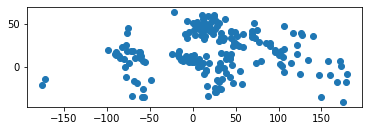

In [5]:
capitals = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
capitals.plot()
print(capitals['geometry'].x)

In [6]:
def d(x,y):
    return np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)

def min_dist(point,list):
    list.sort(key=lambda x:d(point,x))    
    return d(list[0],point)

X,Y=capitals['geometry'].x,capitals['geometry'].y 
capitals=[[X.iloc[i],Y.iloc[i]] for i in range(len(capitals))]

def build_dist(df):
    centroids_x=df.centroid.x
    centroids_y=df.centroid.y
    new_df=[]
    for i in range(len(df)):
        centroid=[centroids_x.iloc[i],centroids_y.iloc[i]]
        min_distance=min_dist(centroid,capitals)
        dic={}
        dic['dist_to_capitals']=min_distance
        new_df.append(dic)
    return new_df



In [7]:
new_df_train=pd.DataFrame(build_dist(train_df))
new_df_train.to_csv('dist_to_capitals_train.csv')

In [9]:
new_df_test=pd.DataFrame(build_dist(test_df))
new_df_test.to_csv('dist_to_capitals_test.csv')

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


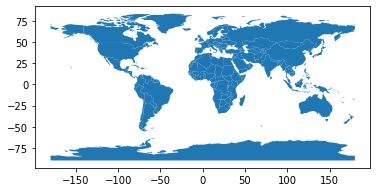

In [50]:
countries=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries.plot()
countries.head()

In [51]:
countries_geom=countries['geometry']
countries_name=countries['name']
def find_country(df):
    polygons=df['geometry']
    new_df=[]
    for i in range(len(df)):
        dic={}
        for j in range(len(countries)):
                if countries_geom.iloc[j].contains(polygons.iloc[i]):
                    dic['country']=countries_name.iloc[j]
                    new_df.append(dic)
                    break
    return new_df

new_df_train=pd.DataFrame(find_country(train_df))
new_df_test=pd.DataFrame(find_country(test_df))
print(new_df_test.head())
print(new_df_train.head())




  country
0   China
1   China
2   China
3   China
4   China
  country
0   China
1   China
2   China
3   China
4   China


In [52]:
new_df_train = pd.concat(
    [new_df_train, new_df_train["country"].str.get_dummies()], axis=1
)
new_df_test = pd.concat(
    [new_df_test, new_df_test["country"].str.get_dummies()], axis=1
)


new_df_train=new_df_train.drop('country',axis=1)
new_df_test=new_df_test.drop('country',axis=1)


new_df_train.to_csv('countries_train.csv')
new_df_test.to_csv('countries_test.csv')

In [53]:
new_df_train=pd.read_csv('countries_train.csv',index_col=0)
new_df_test=pd.read_csv('countries_test.csv',index_col=0)

missing_test=[x for x in new_df_train.columns if x not in new_df_test.columns]
missing_train=[x for x in new_df_test.columns if x not in new_df_train.columns]
print(missing_test)
print(missing_train)
aug=list()
for i in range(len(new_df_train)):
    dic={}
    for c in missing_train:
        dic[c]=0
    aug.append(dic)
aug_train=pd.DataFrame(aug)

aug=list()
for i in range(len(new_df_test)):
    dic={}
    for c in missing_test:
        dic[c]=0
    aug.append(dic)
aug_test=pd.DataFrame(aug)

new_df_train=pd.concat([new_df_train,aug_train],axis=1)
new_df_test=pd.concat([new_df_test,aug_test],axis=1)


new_df_train.to_csv('countries_train.csv')
new_df_test.to_csv('countries_test.csv')

['Dem. Rep. Congo', 'Ethiopia', 'Japan', 'Palestine', 'Saudi Arabia']
['Bhutan', 'Italy', 'Mongolia', 'Russia']


In [54]:
print(new_df_train.columns)
print(new_df_test.columns)
print(new_df_train.shape,new_df_test.shape)



Index(['Algeria', 'Angola', 'Australia', 'Bangladesh', 'Canada', 'China',
       'Côte d'Ivoire', 'Dem. Rep. Congo', 'Egypt', 'Ethiopia', 'France',
       'India', 'Israel', 'Japan', 'Kenya', 'Laos', 'Mexico', 'Palestine',
       'Qatar', 'Saudi Arabia', 'South Africa', 'Sweden', 'Tanzania',
       'United Arab Emirates', 'United States of America', 'Vietnam', 'Bhutan',
       'Italy', 'Mongolia', 'Russia'],
      dtype='object')
Index(['Algeria', 'Angola', 'Australia', 'Bangladesh', 'Bhutan', 'Canada',
       'China', 'Côte d'Ivoire', 'Egypt', 'France', 'India', 'Israel', 'Italy',
       'Kenya', 'Laos', 'Mexico', 'Mongolia', 'Qatar', 'Russia',
       'South Africa', 'Sweden', 'Tanzania', 'United Arab Emirates',
       'United States of America', 'Vietnam', 'Dem. Rep. Congo', 'Ethiopia',
       'Japan', 'Palestine', 'Saudi Arabia'],
      dtype='object')
(308511, 30) (120580, 30)
